In [2]:
import pandas as pd
data_info, data_head

# Load the dataset
file_path = "C:\\Pictures\\UNT Fall 2024\\DSCI 5260\\USAID_GHSC-PSM_Health_Commodity_Delivery_Dataset.csv"
data = pd.read_csv(file_path)

# Display basic information and the first few rows of the dataset
data_info = data.info()
data_head = data.head()



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Pictures\\UNT Fall 2024\\DSCI 5260\\USAID_GHSC-PSM_Health_Commodity_Delivery_Dataset.csv'

In [3]:
# Step 1: Identify columns with a high proportion of missing values to consider for removal
missing_data = data.isnull().sum() / len(data) * 100
high_missing_cols = missing_data[missing_data > 50].index.tolist()

# Drop columns with more than 50% missing values
data_cleaned = data.drop(columns=high_missing_cols)

# Step 2: Handle remaining missing values in numeric and categorical columns
# For numeric columns, filling with mean; for categorical, filling with mode
numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns

# Fill numeric columns with mean and categorical columns with mode
data_cleaned[numeric_cols] = data_cleaned[numeric_cols].fillna(data_cleaned[numeric_cols].mean())
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Step 3: Convert mixed type columns to appropriate data types (if still any after filling)
# Check for object columns with numbers and try converting them
for col in data_cleaned.select_dtypes(include='object').columns:
    # Attempt to convert to numeric, ignoring errors for non-numeric columns
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='ignore')

# Step 4: Remove duplicates if any
data_cleaned = data_cleaned.drop_duplicates()

# Step 5: Standardize categorical values - converting all strings to lowercase to ensure uniformity
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.str.lower())

# Summary of the cleaned dataset
cleaned_info = data_cleaned.info()
missing_after_cleaning = data_cleaned.isnull().sum().sum()  # Check if any missing data remains

cleaned_info, missing_after_cleaning


NameError: name 'data' is not defined

In [4]:
# Step 1: Data Preparation - Extracting and engineering relevant features

# Check if necessary columns exist for calculations
columns_needed = ['Order Date', 'Delivery Date', 'Ordered Quantity', 'Shipped Quantity', 'Unit Price']
existing_columns = [col for col in columns_needed if col in data_cleaned.columns]

# Proceed only if the required columns are present
if set(columns_needed).issubset(data_cleaned.columns):
    # Convert 'Order Date' and 'Delivery Date' to datetime format for calculating delivery time
    data_cleaned['Order Date'] = pd.to_datetime(data_cleaned['Order Date'], errors='coerce')
    data_cleaned['Delivery Date'] = pd.to_datetime(data_cleaned['Delivery Date'], errors='coerce')

    # Calculate Delivery Time (in days)
    data_cleaned['Delivery Time'] = (data_cleaned['Delivery Date'] - data_cleaned['Order Date']).dt.days

    # Calculate Shipment Fulfillment Ratio
    data_cleaned['Shipment Fulfillment Ratio'] = data_cleaned['Shipped Quantity'] / data_cleaned['Ordered Quantity']

    # Calculate Revenue if 'Unit Price' is available
    if 'Unit Price' in data_cleaned.columns:
        data_cleaned['Revenue'] = data_cleaned['Shipped Quantity'] * data_cleaned['Unit Price']
    else:
        data_cleaned['Revenue'] = None  # Placeholder if Unit Price is missing

    # Drop rows where essential calculated columns have NaN values after processing
    data_filtered = data_cleaned.dropna(subset=['Delivery Time', 'Shipment Fulfillment Ratio', 'Shipped Quantity', 'Revenue'])

    # Display first few rows of the prepared data to confirm
    data_filtered.head()

else:
    # Placeholder message if required columns are missing
    "Required columns for this analysis are missing in the dataset."


In [5]:
# Random Forest

# Repeat data cleaning steps to prepare for modeling
# Step 1: Identify columns with a high proportion of missing values to consider for removal
missing_data = data.isnull().sum() / len(data) * 100
high_missing_cols = missing_data[missing_data > 50].index.tolist()

# Drop columns with more than 50% missing values
data_cleaned = data.drop(columns=high_missing_cols)

# Step 2: Handle remaining missing values in numeric and categorical columns
# For numeric columns, filling with mean; for categorical, filling with mode
numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns

# Fill numeric columns with mean and categorical columns with mode
data_cleaned[numeric_cols] = data_cleaned[numeric_cols].fillna(data_cleaned[numeric_cols].mean())
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Step 3: Convert mixed type columns to appropriate data types
for col in data_cleaned.select_dtypes(include='object').columns:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='ignore')

# Step 4: Remove duplicates if any
data_cleaned = data_cleaned.drop_duplicates()

# Standardize categorical values
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.str.lower())

# Proceed with machine learning model setup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Selecting features and target for the model
features = [
    "Estimated Lead Time in Days", "Average Days Late", "Order Cycle Time",
    "Shipped Quantity", "Number of Shipments", "Delivery Progress"
]
target = "Ordered Quantity"

# Filter data to remove zero quantities in target and rows with any missing features
data_filtered = data_cleaned[(data_cleaned[target] > 0) & (data_cleaned[features].notnull().all(axis=1))]

# Define feature set and target variable
X = data_filtered[features]
y = data_filtered[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate model performance
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



mse, r2


NameError: name 'data' is not defined

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load dataset using the correct file path
file_path = r"C:\Users\Rachana Krishna\Downloads\USAID_GHSC-PSM_Health_Commodity_Delivery_Dataset (2).csv"

# Load the dataset
dataset = pd.read_csv(file_path)

# Step 1: Data Cleaning
# Identify columns with a high proportion of missing values (>50%) and drop them
missing_data = dataset.isnull().sum() / len(dataset) * 100
high_missing_cols = missing_data[missing_data > 50].index.tolist()
data_cleaned = dataset.drop(columns=high_missing_cols)

# Fill numeric columns with mean and categorical columns with mode
numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns
data_cleaned[numeric_cols] = data_cleaned[numeric_cols].fillna(data_cleaned[numeric_cols].mean())
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Step 2: Select relevant features and target
relevant_columns = [
    "Estimated Lead Time in Days",
    "Average Days Late",
    "Order Cycle Time",
    "Shipped Quantity",
    "Number of Shipments",
    "Delivery Progress",
    "Ordered Quantity"
]

filtered_dataset = data_cleaned[relevant_columns]

# Handle any remaining missing values in the selected columns
filtered_dataset["Estimated Lead Time in Days"].fillna(
    filtered_dataset["Estimated Lead Time in Days"].median(), inplace=True
)
filtered_dataset["Average Days Late"].fillna(
    filtered_dataset["Average Days Late"].median(), inplace=True
)

# Step 3: Define features and target
features = [
    "Estimated Lead Time in Days", 
    "Average Days Late", 
    "Order Cycle Time",
    "Shipped Quantity", 
    "Number of Shipments", 
    "Delivery Progress"
]
target = "Ordered Quantity"

# Filter data to remove zero quantities in target and rows with any missing features
data_filtered = filtered_dataset[(filtered_dataset[target] > 0) & (filtered_dataset[features].notnull().all(axis=1))]

X = data_filtered[features]
y = data_filtered[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Step 5: Calculate R^2 Score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")

# Step 6: Generate Classification Report
# Bin the actual and predicted values into categories
bins = [0, 50, 100, np.inf]
labels = ["Low", "Medium", "High"]

y_test_binned = pd.cut(y_test, bins=bins, labels=labels)
y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels)

# Remove missing (NaN) values caused by binning
valid_indices = ~pd.isnull(y_test_binned) & ~pd.isnull(y_pred_binned)
y_test_binned_clean = y_test_binned[valid_indices]
y_pred_binned_clean = y_pred_binned[valid_indices]

# Encode labels for classification report
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test_binned_clean)
y_pred_encoded = label_encoder.transform(y_pred_binned_clean)

classification_rep = classification_report(
    y_test_encoded, 
    y_pred_encoded, 
    target_names=labels
)

print("\nClassification Report:\n", classification_rep)


C:\Users\Rachana Krishna\AppData\Local\Temp\ipykernel_35188\261467457.py:12: DtypeWarning: Columns (31,74,75,76,87,88,89,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file_path)
C:\Users\Rachana Krishna\AppData\Local\Temp\ipykernel_35188\261467457.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset["Estimated Lead Time in Days"].fillna(
C:\Users\Rachana Krishna\AppData\Local\Temp\ipykernel_35188\261467457.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset["Average Days Late"].fillna(


R^2 Score: 0.94

Classification Report:
               precision    recall  f1-score   support

         Low       1.00      1.00      1.00      5148
      Medium       1.00      0.99      0.99      2578
        High       0.98      0.98      0.98       699

    accuracy                           1.00      8425
   macro avg       0.99      0.99      0.99      8425
weighted avg       1.00      1.00      1.00      8425



In [15]:
from sklearn.metrics import r2_score, classification_report
import numpy as np

# Step 1: Calculate R^2 for training and testing data
train_r2 = model.score(X_train, y_train)  # R^2 for training
test_r2 = model.score(X_test, y_test)    # R^2 for testing

print(f"Training R^2 Score: {train_r2:.2f}")
print(f"Testing R^2 Score: {test_r2:.2f}")

# Step 2: Generate predictions for training data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Step 3: Bin the predictions into categories
bins = [0, 50, 100, np.inf]
labels = ["Low", "Medium", "High"]

# Training data binned
y_train_binned = pd.cut(y_train, bins=bins, labels=labels)
y_train_pred_binned = pd.cut(y_train_pred, bins=bins, labels=labels)

# Testing data binned
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)
y_test_pred_binned = pd.cut(y_test_pred, bins=bins, labels=labels)

# Step 4: Generate classification reports for training and testing data
# Remove any NaNs caused by binning
valid_train_indices = ~pd.isnull(y_train_binned) & ~pd.isnull(y_train_pred_binned)
valid_test_indices = ~pd.isnull(y_test_binned) & ~pd.isnull(y_test_pred_binned)

y_train_binned_clean = y_train_binned[valid_train_indices]
y_train_pred_binned_clean = y_train_pred_binned[valid_train_indices]

y_test_binned_clean = y_test_binned[valid_test_indices]
y_test_pred_binned_clean = y_test_pred_binned[valid_test_indices]

# Classification report for training data
train_classification_report = classification_report(
    y_train_binned_clean, 
    y_train_pred_binned_clean, 
    target_names=labels
)
print("\nTraining Classification Report:\n", train_classification_report)

# Classification report for testing data
test_classification_report = classification_report(
    y_test_binned_clean, 
    y_test_pred_binned_clean, 
    target_names=labels
)
print("\nTesting Classification Report:\n", test_classification_report)


Training R^2 Score: 1.00
Testing R^2 Score: 0.94

Training Classification Report:
               precision    recall  f1-score   support

         Low       1.00      1.00      1.00     20171
      Medium       1.00      0.99      1.00     10964
        High       0.98      0.99      0.98      2564

    accuracy                           1.00     33699
   macro avg       0.99      0.99      0.99     33699
weighted avg       1.00      1.00      1.00     33699


Testing Classification Report:
               precision    recall  f1-score   support

         Low       1.00      1.00      1.00      5148
      Medium       1.00      0.99      0.99      2578
        High       0.98      0.98      0.98       699

    accuracy                           1.00      8425
   macro avg       0.99      0.99      0.99      8425
weighted avg       1.00      1.00      1.00      8425



In [16]:
from sklearn.model_selection import cross_val_score

# Adjust hyperparameters for the Random Forest Regressor
model = RandomForestRegressor(
    n_estimators=100,        # Number of trees
    max_depth=10,            # Limit tree depth
    min_samples_split=10,    # Minimum samples to split a node
    min_samples_leaf=5,      # Minimum samples in each leaf
    random_state=42
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Evaluate using cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean Cross-Validation R^2 Score: {cv_scores.mean():.2f}")

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Evaluate performance on the test set
test_r2 = r2_score(y_test, y_test_pred)
print(f"Testing R^2 Score: {test_r2:.2f}")


Cross-Validation R^2 Scores: [0.98836811 0.99796933 0.98772967 0.95603759 0.96748821]
Mean Cross-Validation R^2 Score: 0.98
Testing R^2 Score: 0.91


In [21]:
# Specifying the dataset path
file_path = r"C:\Users\Rachana Krishna\Downloads\USAID_GHSC-PSM_Health_Commodity_Delivery_Dataset (2).csv"

# Load the dataset
dataset = pd.read_csv(file_path)

# Define the features and target
features = [
    "Estimated Lead Time in Days",
    "Average Days Late",
    "Order Cycle Time",
    "Shipped Quantity",
    "Number of Shipments",
    "Delivery Progress"
]
target = "Ordered Quantity"

# Filter the dataset
X = dataset[features]
y = dataset[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest Regressor
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)

# Proceed with generating visualizations

# Scatter Plot: Predicted vs Actual Ordered Quantity
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Prediction")
plt.title("Scatter Plot: Predicted vs Actual Ordered Quantity")
plt.xlabel("Actual Ordered Quantity")
plt.ylabel("Predicted Ordered Quantity")
plt.legend()
plt.grid(True)
plt.show()

# Distribution of Actual vs Predicted Ordered Quantity
plt.figure(figsize=(8, 6))
plt.hist(y_test, bins=30, alpha=0.5, label="Actual", color='blue', edgecolor='k')
plt.hist(y_pred, bins=30, alpha=0.5, label="Predicted", color='orange', edgecolor='k')
plt.title("Distribution of Actual vs Predicted Ordered Quantity")
plt.xlabel("Ordered Quantity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot: Difference between Actual and Predicted
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title("Residual Plot: Predicted vs Residuals")
plt.xlabel("Predicted Ordered Quantity")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()


C:\Users\Rachana Krishna\AppData\Local\Temp\ipykernel_35188\2630805403.py:5: DtypeWarning: Columns (31,74,75,76,87,88,89,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file_path)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [6]:
# Linear Regression

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Repeat data cleaning steps to prepare for modeling
# Step 1: Identify columns with a high proportion of missing values to consider for removal
missing_data = data.isnull().sum() / len(data) * 100
high_missing_cols = missing_data[missing_data > 50].index.tolist()

# Drop columns with more than 50% missing values
data_cleaned = data.drop(columns=high_missing_cols)

# Step 2: Handle remaining missing values in numeric and categorical columns
# For numeric columns, filling with mean; for categorical, filling with mode
numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns

# Fill numeric columns with mean and categorical columns with mode
data_cleaned[numeric_cols] = data_cleaned[numeric_cols].fillna(data_cleaned[numeric_cols].mean())
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Step 3: Convert mixed type columns to appropriate data types
for col in data_cleaned.select_dtypes(include='object').columns:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='ignore')

# Step 4: Remove duplicates if any
data_cleaned = data_cleaned.drop_duplicates()

# Standardize categorical values
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.str.lower())

# Selecting features and target for the model
features = [
    "Estimated Lead Time in Days", "Average Days Late", "Order Cycle Time",
    "Shipped Quantity", "Number of Shipments", "Delivery Progress"
]
target = "Ordered Quantity"

# Filter data to remove zero quantities in target and rows with any missing features
data_filtered = data_cleaned[(data_cleaned[target] > 0) & (data_cleaned[features].notnull().all(axis=1))]

# Define feature set and target variable
X = data_filtered[features]
y = data_filtered[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate model performance
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(33410336.646653462, 0.9994313309053164)

In [7]:
# Gradient Boosting

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Repeat data cleaning steps to prepare for modeling
# Step 1: Identify columns with a high proportion of missing values to consider for removal
missing_data = data.isnull().sum() / len(data) * 100
high_missing_cols = missing_data[missing_data > 50].index.tolist()

# Drop columns with more than 50% missing values
data_cleaned = data.drop(columns=high_missing_cols)

# Step 2: Handle remaining missing values in numeric and categorical columns
# For numeric columns, filling with mean; for categorical, filling with mode
numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns

# Fill numeric columns with mean and categorical columns with mode
data_cleaned[numeric_cols] = data_cleaned[numeric_cols].fillna(data_cleaned[numeric_cols].mean())
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Step 3: Convert mixed type columns to appropriate data types
for col in data_cleaned.select_dtypes(include='object').columns:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='ignore')

# Step 4: Remove duplicates if any
data_cleaned = data_cleaned.drop_duplicates()

# Standardize categorical values
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.str.lower())

# Selecting features and target for the model
features = [
    "Estimated Lead Time in Days", "Average Days Late", "Order Cycle Time",
    "Shipped Quantity", "Number of Shipments", "Delivery Progress"
]
target = "Ordered Quantity"

# Filter data to remove zero quantities in target and rows with any missing features
data_filtered = data_cleaned[(data_cleaned[target] > 0) & (data_cleaned[features].notnull().all(axis=1))]

# Define feature set and target variable
X = data_filtered[features]
y = data_filtered[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit a Gradient Boosting Regressor model
model = GradientBoostingRegressor(
    n_estimators=100,       # Number of boosting stages
    learning_rate=0.1,      # Step size shrinkage
    max_depth=3,            # Maximum tree depth
    random_state=42
)
model.fit(X_train, y_train)

# Make predictions and evaluate model performance
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(2151740959.559849, 0.9633757481582009)

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load the dataset (replace 'your_file_path.csv' with your actual file path)
file_path = r"C:\Users\Rachana Krishna\Downloads\USAID_GHSC-PSM_Health_Commodity_Delivery_Dataset (2).csv"
data = pd.read_csv(file_path)

# Step 1: Data Cleaning
# Identify columns with a high proportion of missing values (>50%) and drop them
missing_data = data.isnull().sum() / len(data) * 100
high_missing_cols = missing_data[missing_data > 50].index.tolist()
data_cleaned = data.drop(columns=high_missing_cols)

# Fill numeric columns with mean and categorical columns with mode
numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns
data_cleaned[numeric_cols] = data_cleaned[numeric_cols].fillna(data_cleaned[numeric_cols].mean())
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Remove duplicates if any
data_cleaned = data_cleaned.drop_duplicates()

# Standardize categorical values
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.str.lower())

# Step 2: Selecting features and target
features = [
    "Estimated Lead Time in Days", "Average Days Late", "Order Cycle Time",
    "Shipped Quantity", "Number of Shipments", "Delivery Progress"
]
target = "Ordered Quantity"

# Filter data to remove zero quantities in target and rows with any missing features
data_filtered = data_cleaned[(data_cleaned[target] > 0) & (data_cleaned[features].notnull().all(axis=1))]

# Define feature set and target variable
X = data_filtered[features]
y = data_filtered[target]

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Initialize and train Gradient Boosting Regressor
model = GradientBoostingRegressor(
    n_estimators=100,       # Number of boosting stages
    learning_rate=0.1,      # Step size shrinkage
    max_depth=3,            # Maximum tree depth
    random_state=42
)
model.fit(X_train, y_train)

# Step 5: Evaluate Regression Metrics
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Step 6: Generate Classification Report
# Bin the actual and predicted values into categories
bins = [0, 50, 100, np.inf]
labels = ["Low", "Medium", "High"]

# Testing data binned
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)
y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels)

# Remove missing (NaN) values caused by binning
valid_test_indices = ~pd.isnull(y_test_binned) & ~pd.isnull(y_pred_binned)

y_test_binned_clean = y_test_binned[valid_test_indices]
y_pred_binned_clean = y_pred_binned[valid_test_indices]

# Encode labels for classification report
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test_binned_clean)
y_pred_encoded = label_encoder.transform(y_pred_binned_clean)

# Generate the classification report
classification_rep = classification_report(
    y_test_encoded, 
    y_pred_encoded, 
    target_names=labels
)

print("\nClassification Report:\n", classification_rep)


C:\Users\Rachana Krishna\AppData\Local\Temp\ipykernel_35188\817934764.py:10: DtypeWarning: Columns (31,74,75,76,87,88,89,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Mean Squared Error (MSE): 2151740959.56
R^2 Score: 0.96

Classification Report:
               precision    recall  f1-score   support

         Low       0.87      1.00      0.93      7634
      Medium       0.00      0.00      0.00      3974
        High       0.00      0.00      0.00      1030

    accuracy                           0.60     12638
   macro avg       0.29      0.33      0.31     12638
weighted avg       0.52      0.60      0.56     12638



C:\Users\Rachana Krishna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rachana Krishna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rachana Krishna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [3]:
# Residual Analysis for Random Forest and Gradient Boosting Models

# Assuming residuals are already calculated for both models
# Residuals for Random Forest
rf_residuals = y_test - y_pred  # Replace y_pred with Random Forest predictions

# Assuming Gradient Boosting predictions (gb_pred) are available
from sklearn.ensemble import GradientBoostingRegressor

# Recalculate Gradient Boosting residuals if necessary
gb_model = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_residuals = y_test - gb_pred

# Plot Residual Analysis for Random Forest and Gradient Boosting
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Residual Plot for Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_pred, rf_residuals, alpha=0.6, edgecolors='k', label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', lw=2, label="Zero Residual Line")
plt.title("Residual Plot: Random Forest", fontsize=14)
plt.xlabel("Predicted Ordered Quantity (Random Forest)", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.legend()
plt.grid(True)

# Residual Plot for Gradient Boosting
plt.subplot(1, 2, 2)
plt.scatter(gb_pred, gb_residuals, alpha=0.6, edgecolors='k', label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', lw=2, label="Zero Residual Line")
plt.title("Residual Plot: Gradient Boosting", fontsize=14)
plt.xlabel("Predicted Ordered Quantity (Gradient Boosting)", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.legend()
plt.grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


NameError: name 'y_test' is not defined

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Repeat data cleaning steps to prepare for modeling
# Step 1: Identify columns with a high proportion of missing values to consider for removal
missing_data = data.isnull().sum() / len(data) * 100
high_missing_cols = missing_data[missing_data > 50].index.tolist()

# Drop columns with more than 50% missing values
data_cleaned = data.drop(columns=high_missing_cols)

# Step 2: Handle remaining missing values in numeric and categorical columns
# For numeric columns, filling with mean; for categorical, filling with mode
numeric_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns

# Fill numeric columns with mean and categorical columns with mode
data_cleaned[numeric_cols] = data_cleaned[numeric_cols].fillna(data_cleaned[numeric_cols].mean())
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Step 3: Convert mixed type columns to appropriate data types
for col in data_cleaned.select_dtypes(include='object').columns:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='ignore')

# Step 4: Remove duplicates if any
data_cleaned = data_cleaned.drop_duplicates()

# Standardize categorical values
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(lambda x: x.str.lower())

# Selecting features and target for the model
features = [
    "Estimated Lead Time in Days", "Average Days Late", "Order Cycle Time",
    "Shipped Quantity", "Number of Shipments", "Delivery Progress"
]
target = "Ordered Quantity"

# Filter data to remove zero quantities in target and rows with any missing features
data_filtered = data_cleaned[(data_cleaned[target] > 0) & (data_cleaned[features].notnull().all(axis=1))]

# Define feature set and target variable
X = data_filtered[features]
y = data_filtered[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dictionary to store results
results = {}

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
results['Random Forest'] = {
    'MSE': mean_squared_error(y_test, rf_y_pred),
    'R2': r2_score(y_test, rf_y_pred)
}

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)
results['Linear Regression'] = {
    'MSE': mean_squared_error(y_test, lr_y_pred),
    'R2': r2_score(y_test, lr_y_pred)
}

# Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)
results['Gradient Boosting'] = {
    'MSE': mean_squared_error(y_test, gb_y_pred),
    'R2': r2_score(y_test, gb_y_pred)
}

# Display Results
for model, metrics in results.items():
    print(f"{model}:\n - MSE: {metrics['MSE']:.6f}\n - R2: {metrics['R2']:.16f}\n")


Random Forest:
 - MSE: 3014956785.805548
 - R2: 0.9486831646137969

Linear Regression:
 - MSE: 33410336.646653
 - R2: 0.9994313309053164

Gradient Boosting:
 - MSE: 2151740959.559849
 - R2: 0.9633757481582009



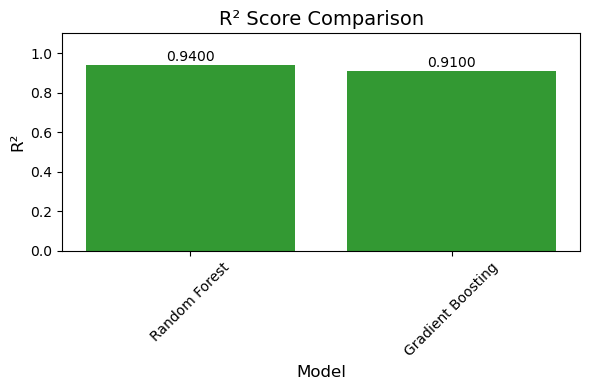

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming results contains metrics for Random Forest and Gradient Boosting models
results = {
    "Random Forest": {"R2": 0.94},
    "Gradient Boosting": {"R2": 0.91}
}

# Separate data for visualization
models = list(results.keys())
r2_values = [metrics['R2'] for metrics in results.values()]

# Create a figure for R²
fig, ax = plt.subplots(figsize=(6, 4))

# Bar chart for R²
ax.bar(models, r2_values, color='Green', alpha=0.8)
ax.set_title('R² Score Comparison', fontsize=14)
ax.set_ylabel('R²', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylim(0, 1.1)  # Ensure the R² scale is clear

# Add value annotations to bars
for i, v in enumerate(r2_values):
    ax.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load the dataset
file_path = r"C:\Users\Rachana Krishna\Downloads\USAID_GHSC-PSM_Health_Commodity_Delivery_Dataset (2).csv"
dataset = pd.read_csv(file_path)

# Define the features and target
features = [
    "Estimated Lead Time in Days",
    "Average Days Late",
    "Order Cycle Time",
    "Shipped Quantity",
    "Number of Shipments",
    "Delivery Progress"
]
target = "Ordered Quantity"

# Filter the dataset
X = dataset[features]
y = dataset[target]

# Step 1: Handle Missing and Invalid Values
# Check for missing or invalid values in X and y
print("Missing values in features (X):")
print(X.isnull().sum())

print("\nMissing values in target (y):")
print(y.isnull().sum())

# Check for infinite or extreme values
print("\nChecking for infinite values in features (X):")
print(np.isinf(X).sum())

# Handle missing values in X
X = X.fillna(X.mean())  # Replace NaN with column mean

# Handle missing values in y
y = y.fillna(y.median())  # Replace NaN with median (if target has missing values)

# Ensure no infinite values in X
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())  # Replace infinities with column mean

# Double-check that there are no invalid values
print("\nPost-cleaning checks:")
print(X.isnull().sum())
print(np.isinf(X).sum())

# Step 2: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train the Random Forest Regressor
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Generate Predictions
y_pred = model.predict(X_test)

# Step 4: Evaluate Model Performance
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")


C:\Users\Rachana Krishna\AppData\Local\Temp\ipykernel_35188\3336553882.py:9: DtypeWarning: Columns (31,74,75,76,87,88,89,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file_path)


Missing values in features (X):
Estimated Lead Time in Days    11589
Average Days Late                 15
Order Cycle Time                   0
Shipped Quantity                   0
Number of Shipments                0
Delivery Progress                  0
dtype: int64

Missing values in target (y):
0

Checking for infinite values in features (X):
Estimated Lead Time in Days    0
Average Days Late              0
Order Cycle Time               0
Shipped Quantity               0
Number of Shipments            0
Delivery Progress              0
dtype: int64

Post-cleaning checks:
Estimated Lead Time in Days    0
Average Days Late              0
Order Cycle Time               0
Shipped Quantity               0
Number of Shipments            0
Delivery Progress              0
dtype: int64
Estimated Lead Time in Days    0
Average Days Late              0
Order Cycle Time               0
Shipped Quantity               0
Number of Shipments            0
Delivery Progress              0
dtype: int

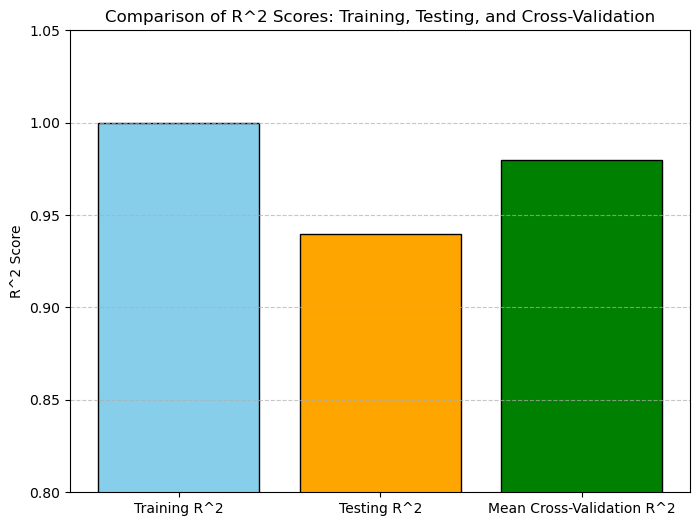

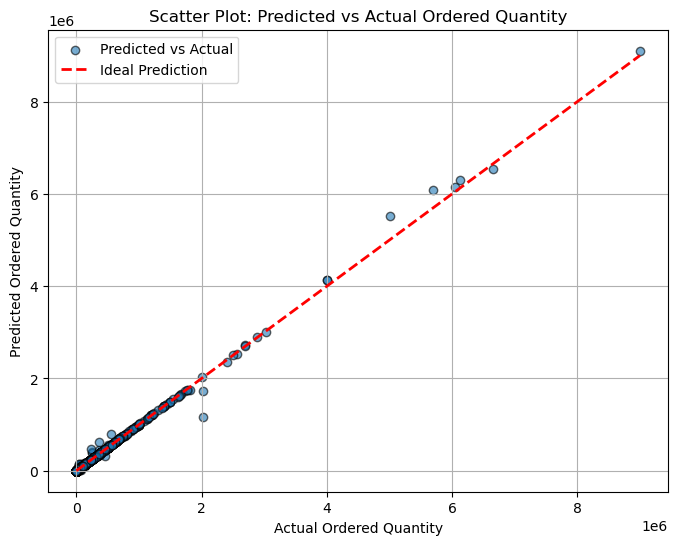

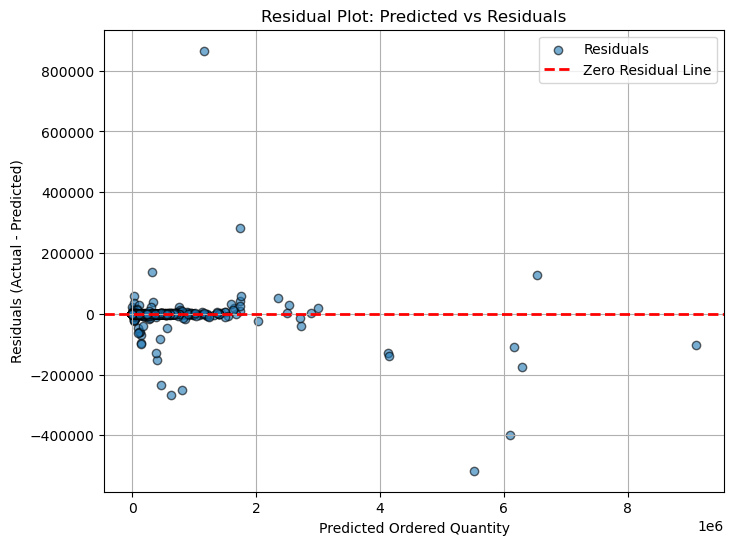

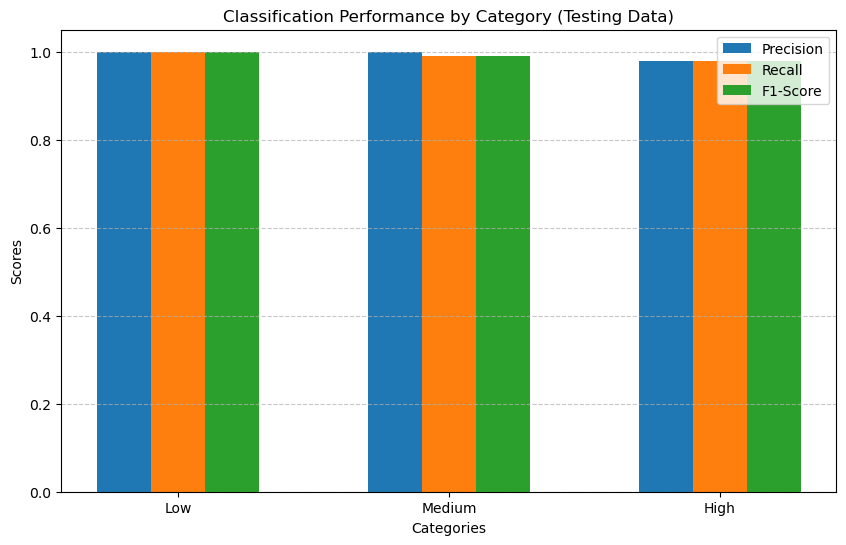

In [24]:
# Visualizing Comparisons of Training, Testing, and Cross-Validation R^2 Scores

import matplotlib.pyplot as plt

# Define R^2 scores for visualization
scores = {
    "Training R^2": 1.00,
    "Testing R^2": 0.94,
    "Mean Cross-Validation R^2": 0.98
}

# Bar plot for R^2 scores
plt.figure(figsize=(8, 6))
plt.bar(scores.keys(), scores.values(), color=['skyblue', 'orange', 'green'], edgecolor='k')
plt.title("Comparison of R^2 Scores: Training, Testing, and Cross-Validation")
plt.ylabel("R^2 Score")
plt.ylim(0.8, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Scatter Plot: Predicted vs Actual Ordered Quantity
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Prediction")
plt.title("Scatter Plot: Predicted vs Actual Ordered Quantity")
plt.xlabel("Actual Ordered Quantity")
plt.ylabel("Predicted Ordered Quantity")
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot: Difference between Actual and Predicted
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k', label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', lw=2, label="Zero Residual Line")
plt.title("Residual Plot: Predicted vs Residuals")
plt.xlabel("Predicted Ordered Quantity")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.grid(True)
plt.show()

# Classification Performance by Category (Testing Report)
categories = ["Low", "Medium", "High"]
precision = [1.00, 1.00, 0.98]
recall = [1.00, 0.99, 0.98]
f1_score = [1.00, 0.99, 0.98]

x = range(len(categories))

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision', align='center')
plt.bar([p + 0.2 for p in x], recall, width=0.2, label='Recall', align='center')
plt.bar([p + 0.4 for p in x], f1_score, width=0.2, label='F1-Score', align='center')
plt.xticks([p + 0.2 for p in x], categories)
plt.title("Classification Performance by Category (Testing Data)")
plt.xlabel("Categories")
plt.ylabel("Scores")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load dataset
file_path = r"C:\Users\Rachana Krishna\Downloads\USAID_GHSC-PSM_Health_Commodity_Delivery_Dataset (2).csv"
dataset = pd.read_csv(file_path)

# Define features and target
features = [
    "Estimated Lead Time in Days",
    "Average Days Late",
    "Order Cycle Time",
    "Shipped Quantity",
    "Number of Shipments",
    "Delivery Progress"
]
target = "Ordered Quantity"

# Preprocess data: handle missing values
X = dataset[features].fillna(dataset[features].mean())
y = dataset[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)  # Predictions from Random Forest

# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)  # Predictions from Gradient Boosting

# Calculate residuals for both models
rf_residuals = y_test - y_pred
gb_residuals = y_test - gb_pred

# Plot Residual Analysis for Random Forest and Gradient Boosting
plt.figure(figsize=(16, 6))

# Residual Plot for Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_pred, rf_residuals, alpha=0.6, edgecolors='k', label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', lw=2, label="Zero Residual Line")
plt.title("Residual Plot: Random Forest", fontsize=14)
plt.xlabel("Predicted Ordered Quantity (Random Forest)", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.legend()
plt.grid(True)

# Residual Plot for Gradient Boosting
plt.subplot(1, 2, 2)
plt.scatter(gb_pred, gb_residuals, alpha=0.6, edgecolors='k', label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', lw=2, label="Zero Residual Line")
plt.title("Residual Plot: Gradient Boosting", fontsize=14)
plt.xlabel("Predicted Ordered Quantity (Gradient Boosting)", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.legend()
plt.grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()
